In [1]:
import warnings
import json
from pandas.io.json import json_normalize

warnings.filterwarnings(action='ignore')
import numpy as np  # 수치계산, 배열 처리를 위해 import 한다.
import pandas as pd  # 데이터 분석을 위한 전처리를 위해 import 한다.
import matplotlib as mpl  # matplolib에서 음수 데이터의 '-'부호가 깨지는 것을 방지하기위해 import 한다.

mpl.rcParams['axes.unicode_minus'] = False  # matplolib에서 음수 데이터의 '-'부호가 깨지는 것을 방지한다.
import matplotlib.pyplot as plt  # 시각화를 하기 위해 import 한다.

plt.rcParams["font.size"] = 10  # matplolib에서 사용할 글꼴 크기 설정
plt.rcParams["font.family"] = "NanumGothicCoding"  # matplolib에서 사용할 글꼴 설정
import seaborn as sns  # 시각화를 하기 위해 import 한다. matplolib 기반으로 만든 시각화 도구

pd.options.display.float_format = '{:,.5f}'.format
import missingno as msno  # 누락값의 분포를 그래프 형태로 보기위해 import 한다.

In [2]:
rank = pd.read_csv('data/rank.csv')
rank_final = pd.read_csv('data/rank_final - changed.csv')

In [3]:
characterNamesEn = pd.read_csv('data/characterList - origin.csv')  # 캐릭터 영문명
characterNamesKr = pd.read_csv('data/characterList - changed.csv')  # 캐릭터 한글명
skinNames = pd.read_csv('data/skin - changed.csv')  # 스킨
weaponNames = pd.read_csv('data/weapon - changed.csv')  # 무기
armorNames = pd.read_csv('data/armor - changed.csv')  # 방어구
# 무기별 사용캐릭터 추가
weapon = pd.DataFrame({'num': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25],
                       'name': ["글러브", "톤파", "방망이", "채찍", "투척", "암기", "활", "석궁", "권총", "돌격소총", "저격총", "망치", "도끼", "단검", "양손검", "쌍검", "창", "쌍절곤", "레이피어", "기타", "카메라", "아르카나", "VF의수"],
                       'character':[['현우', '레온', '얀', '니키', '리다이린'],['현우', '레온', '얀', '아이작', '알렉스'],['바바라', '매그너스', '루크', '띠아'],['레녹스', '마이', '라우라'],
                                    ['시셀라', '이바', '이렘', '아드리아나', '윌리엄', '자히르', '셀린'],['시셀라', '엠마', '자히르', '타지아', '클로에', '혜진', '알렉스'],
                                    ['리오', '나딘', '혜진'],['나딘', '칼라'],['아야', '로지', '제니', '아이솔', '실비아', '알렉스'],['아야', '아이솔', '헤이즈'],
                                    ['아야', '버니스', '테오도르'],['매그너스', '수아', '일레븐'],['재키', '마커스', '에스텔'],['재키', '쇼이치', '캐시', '다니엘', '쇼우'],
                                    ['재키', '유키', '피오라', '에이든', '알렉스'],['재키', '카밀로', '유키', '캐시'],['쇼우', '펠릭스', '피오라'],['리다이린', '피올로'],
                                    ['피오라', '키아라', '카밀로', '아델라', '엘레나'],['하트', '프리야'],['나타폰', '마르티나'],['요한', '비앙카', '엠마', '아디나'],['에키온']]})

In [4]:
%%time
characterList = pd.DataFrame()

for i in range(len(rank_final.nameW.value_counts())):
    gg = f'{"{"}"nameW" : "{rank_final.nameW.value_counts().index[i]}","code" : {rank_final[rank_final.nameW == rank_final.nameW.value_counts().index[i]].characterNum.values[0]}{"}"}'

    characterList = pd.concat([characterList, json_normalize(json.loads(gg))], ignore_index=True)
characterList = characterList.sort_values('code')
characterList = characterList.reset_index(drop=True)
characterList


Wall time: 467 ms


,nameW,code
0,재키(단검),1
1,재키(쌍검),1
2,재키(양손검),1
3,재키(도끼),1
4,아야(저격총),2
...,...,...
79,헤이즈(돌격소총),58
80,아이작(톤파),59
81,타지아(암기),60
82,이렘(투척),61


In [5]:
%%time
# 62개 캐릭터의 핵심 정보

df_code = pd.DataFrame()
df_characterStats = pd.DataFrame()

for i in range(84):
    character = pd.concat([df_code, rank_final[rank_final.nameW==characterList.nameW[i]]])
    stat = (
        # 실험체 이름
        f'{"{"}"characterName" : "{characterList.nameW[i]}", '
        # 실험체 번호
        f'"characterCode" : {characterList.code[i]}, '
        # 가장 많이 사용한 스킨, 사용 횟수
        f'"mostSkin" : "{skinNames[skinNames.code == int(character.skinCode.value_counts().head(1).index[0])].values[0][0]}", "mostSkinCount" : {character.skinCode.value_counts().head(1).values[0]}, '

        # 무기(이대로 사용하면 가장 많이 사용한 무기로 나머지 무기도 통합됨)
        f'"characterWeapon" : "{weapon[weapon.num==character.bestWeapon.values[0]].name.values[0]}",'

        # 여기부터 마지막까지 아래와 같은 리스트형식으로 무기별 분류 필요
        #  ([ {무기군1: 킬수}, {무기군2 : 킬수} ...])
        #  ([ {무기군1: 루트무기}, {무기군2 : 루트무기} ...] )

        # 평균 플레이어 킬수
        f'"averageKillPlayer" : {character.playerKill.mean():.2f}, '
        # 평균 플레이어 데미지
        f'"averageDamegeToPlayer" : {character.damageToPlayer.mean():.2f}, '
        # 평균 야동 킬수
        f'"averageKillMonster" : {character.monsterKill.mean():.2f}, '
        # 평균 야동 데미지
        f'"averageDamegeToMonster" : {character.damageToMonster.mean():.2f}, '
        # 게임 플레이 수
        f'"totalGames" : {character.count()[0]}, '
        # # 평균 승률 => 자히르 투척 승률 0%짜리 터짐
        f'"winRate" : {character[character.victory == 1].victory.count() / character.victory.count():.2f}, '

        # 평균 등수
        f'"averageRank" : {character[character.escapeState != 3].gameRank.mean():.2f}, '
        # 탈출 횟수
        f'"escapeCount" : {character[character.escapeState == 3].escapeState.count()}, '
        # 평균 mmr 획득률
        f'"averageMMR" : {character.mmrGain.mean():.2f}, '
        # 픽률
        f'"pickRate" : {character.count()[0] / 19248 * 100:.2f},'


        # 최종 아이템, 사용 횟수
        f'"finalWeapon" : "{weaponNames[weaponNames.code == int(character["equipment.0"].value_counts().head(1).index[0])].values[0][1]}", "finalWeaponCount" : {character["equipment.0"].value_counts().head(1).values[0]}, '
        f'"finalBody" : "{armorNames[armorNames.code == int(character["equipment.1"].value_counts().head(1).index[0])].values[0][1]}", "finalBodyCount" : {character["equipment.1"].value_counts().head(1).values[0]}, '
        f'"finalHead" : "{armorNames[armorNames.code == int(character["equipment.2"].value_counts().head(1).index[0])].values[0][1]}", "finalHeadCount" : {character["equipment.2"].value_counts().head(1).values[0]}, '
        f'"finalArm" : "{armorNames[armorNames.code == int(character["equipment.3"].value_counts().head(1).index[0])].values[0][1]}", "finalArmCount" : {character["equipment.3"].value_counts().head(1).values[0]}, '
        f'"finalFoot" : "{armorNames[armorNames.code == int(character["equipment.4"].value_counts().head(1).index[0])].values[0][1]}", "finalFootCount" : {character["equipment.4"].value_counts().head(1).values[0]}, '
        f'"finalTinkled" : "{armorNames[armorNames.code == int(character["equipment.5"].value_counts().head(1).index[0])].values[0][1]}", "finalTinkledCount" : {character["equipment.5"].value_counts().head(1).values[0]}, '

        # 가장 많이 선택한 루트 아이템, 사용 횟수
        f'"routeWeapon" : "{weaponNames[weaponNames.code == int(character["equipFirstItemForLog.0"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeWeaponCount" : {character["equipFirstItemForLog.0"].value_counts().head(1)[0]}, '
        f'"routeBody" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.1"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeBodyCount" : {character["equipFirstItemForLog.1"].value_counts().head(1)[0]}, '
        f'"routeHead" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.2"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeHeadCount" : {character["equipFirstItemForLog.2"].value_counts().head(1)[0]}, '
        f'"routeArm" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.3"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeArmCount" : {character["equipFirstItemForLog.3"].value_counts().head(1)[0]}, '
        f'"routeFoot" : "{armorNames[armorNames.code == int(character["equipFirstItemForLog.4"].value_counts().head(1).index[0][1:-1])].values[0][1]}", "routeFootCount" : {character["equipFirstItemForLog.4"].value_counts().head(1)[0]}, '

        f'"routeTinkled" : "", "routeTinkledCount" : ""{"}"}'
    )
    df_characterStats = pd.concat([df_characterStats, json_normalize(json.loads(stat))],ignore_index=True)
    del character, stat
df_characterStats


Wall time: 2.91 s


,characterName,characterCode,mostSkin,mostSkinCount,characterWeapon,averageKillPlayer,averageDamegeToPlayer,averageKillMonster,averageDamegeToMonster,totalGames,...,routeBody,routeBodyCount,routeHead,routeHeadCount,routeArm,routeArmCount,routeFoot,routeFootCount,routeTinkled,routeTinkledCount
0,재키(단검),1,스칼렛 코사지 재키,87,단검,2.88000,"8,349.14000",30.48000,"40,503.32000",219,...,성기사의갑옷,89,수정티아라,100,바이탈센서,168,경량화부츠,169,,
1,재키(쌍검),1,시스템쇼크 재키,78,쌍검,3.56000,"9,508.02000",28.12000,"34,974.54000",206,...,광학미채수트,63,수정티아라,119,바이탈센서,149,부케팔로스,126,,
2,재키(양손검),1,재키,84,양손검,2.55000,"7,205.29000",29.46000,"38,669.75000",167,...,광학미채수트,102,수정티아라,116,바이탈센서,98,부케팔로스,99,,
3,재키(도끼),1,시스템쇼크 재키,35,도끼,2.41000,"7,121.12000",30.71000,"37,961.72000",69,...,턱시도,40,성기사의투구,37,플라즈마아크,43,매버릭러너,37,,
4,아야(저격총),2,불꽃놀이 아야,413,저격총,2.66000,"11,468.78000",20.37000,"25,525.72000",607,...,지휘관의갑옷,454,황실부르고넷,402,틴달로스의팔찌,495,타키온브레이스,452,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,헤이즈(돌격소총),58,암흑가 헤이즈,224,돌격소총,2.46000,"11,080.11000",18.20000,"21,879.78000",386,...,지휘관의갑옷,266,황실부르고넷,295,틴달로스의팔찌,256,아이젠,242,,
80,아이작(톤파),59,암흑가 아이작,309,톤파,2.43000,"7,372.01000",18.62000,"21,601.14000",512,...,EOD수트,354,전술OPS헬멧,397,샤자한의검집,378,경량화부츠,281,,
81,타지아(암기),60,타지아,39,암기,3.33000,"9,196.26000",13.47000,"16,505.85000",66,...,고위사제복,57,제국왕관,60,아이기스,44,SCV,41,,
82,이렘(투척),61,눈싸움 이렘,107,투척,2.15000,"7,031.30000",15.59000,"18,930.38000",138,...,EOD수트,96,제국왕관,124,스포츠시계,80,타키온브레이스,56,,


In [6]:
df_characterStats.characterName[45]='알렉스'
print(df_characterStats.characterName[45])
characterList.nameW[45]='알렉스'
print(characterList.nameW[45])

알렉스
알렉스


In [7]:
df_characterStats

,characterName,characterCode,mostSkin,mostSkinCount,characterWeapon,averageKillPlayer,averageDamegeToPlayer,averageKillMonster,averageDamegeToMonster,totalGames,...,routeBody,routeBodyCount,routeHead,routeHeadCount,routeArm,routeArmCount,routeFoot,routeFootCount,routeTinkled,routeTinkledCount
0,재키(단검),1,스칼렛 코사지 재키,87,단검,2.88000,"8,349.14000",30.48000,"40,503.32000",219,...,성기사의갑옷,89,수정티아라,100,바이탈센서,168,경량화부츠,169,,
1,재키(쌍검),1,시스템쇼크 재키,78,쌍검,3.56000,"9,508.02000",28.12000,"34,974.54000",206,...,광학미채수트,63,수정티아라,119,바이탈센서,149,부케팔로스,126,,
2,재키(양손검),1,재키,84,양손검,2.55000,"7,205.29000",29.46000,"38,669.75000",167,...,광학미채수트,102,수정티아라,116,바이탈센서,98,부케팔로스,99,,
3,재키(도끼),1,시스템쇼크 재키,35,도끼,2.41000,"7,121.12000",30.71000,"37,961.72000",69,...,턱시도,40,성기사의투구,37,플라즈마아크,43,매버릭러너,37,,
4,아야(저격총),2,불꽃놀이 아야,413,저격총,2.66000,"11,468.78000",20.37000,"25,525.72000",607,...,지휘관의갑옷,454,황실부르고넷,402,틴달로스의팔찌,495,타키온브레이스,452,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,헤이즈(돌격소총),58,암흑가 헤이즈,224,돌격소총,2.46000,"11,080.11000",18.20000,"21,879.78000",386,...,지휘관의갑옷,266,황실부르고넷,295,틴달로스의팔찌,256,아이젠,242,,
80,아이작(톤파),59,암흑가 아이작,309,톤파,2.43000,"7,372.01000",18.62000,"21,601.14000",512,...,EOD수트,354,전술OPS헬멧,397,샤자한의검집,378,경량화부츠,281,,
81,타지아(암기),60,타지아,39,암기,3.33000,"9,196.26000",13.47000,"16,505.85000",66,...,고위사제복,57,제국왕관,60,아이기스,44,SCV,41,,
82,이렘(투척),61,눈싸움 이렘,107,투척,2.15000,"7,031.30000",15.59000,"18,930.38000",138,...,EOD수트,96,제국왕관,124,스포츠시계,80,타키온브레이스,56,,


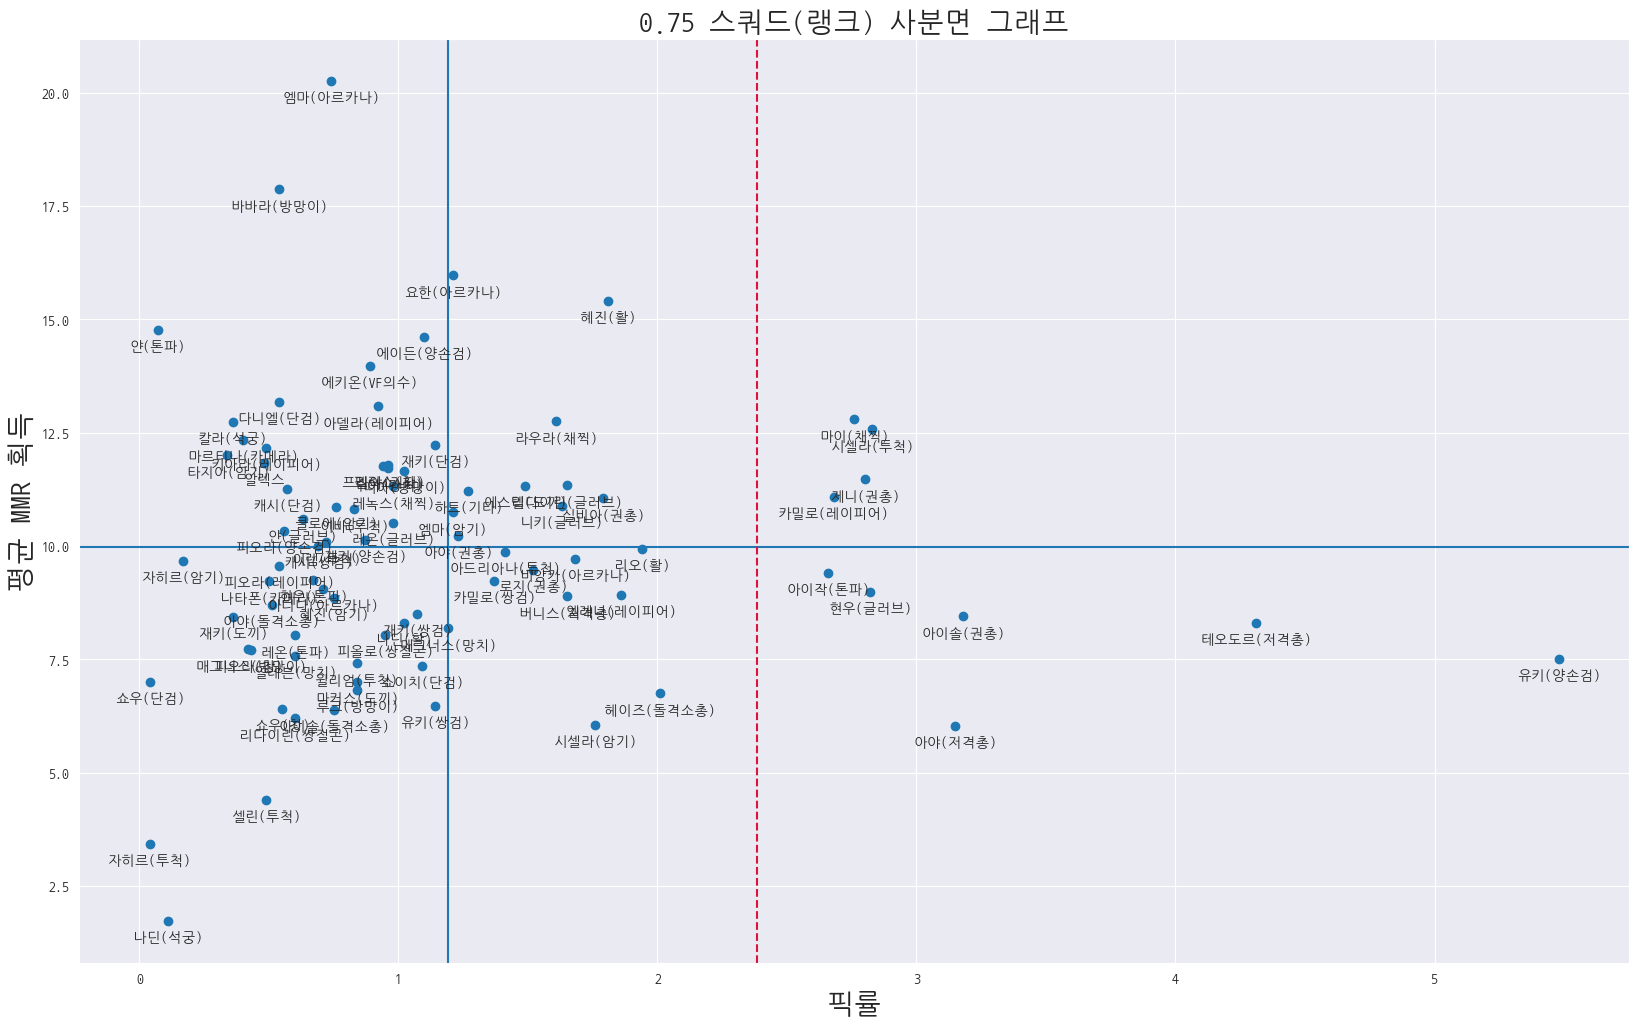

In [8]:
mmr = df_characterStats.averageMMR.mean()
pick = df_characterStats.pickRate.mean()
xy = pd.DataFrame()
for i, char in df_characterStats.iterrows():
    xy = pd.concat([xy, json_normalize(json.loads(
        f'{"{"}"characterCode" : {characterList[characterList.nameW == char.characterName].code.values[0]} ,"characterName" : "{characterList[characterList.nameW == char.characterName].nameW.values[0]}" ,"pickRate" : {df_characterStats.totalGames[i] / 19247 * 100:.2f}, "mmrGain" : {df_characterStats.averageMMR[i]:.2f}{"}"}'))])

plt.figure(figsize=(20, 12))


plt.xlabel('픽률',fontsize=20)
plt.ylabel('평균 MMR 획득', fontsize=20)
plt.scatter(xy.pickRate, xy.mmrGain, )
plt.title('0.75 스쿼드(랭크) 사분면 그래프', fontsize=20)
for _, j in xy.iterrows():
    plt.annotate(j.characterName,
                 (j.pickRate, j.mmrGain),
                 textcoords="offset points",  # 텍스트 위치를 (x,y)로 부터의 오프셋 (offset_x, offset_y)로 지정
                 xytext=(0, -15),  # (x, y)로 부터의 오프셋 (offset_x, offset_y), 여기에선 y 좌표로 +20 이동합니다.
                 ha='center')

plt.axhline(mmr, 0, 1)
plt.axvline(pick, 0, 1)
plt.axvline(pick*2, 0, 1, linestyle='--', color='crimson')
plt.show()

무기: 뚜언띠엔, 옷: 지휘관의갑옷, 머리: 제국왕관, 팔: 틴달로스의팔찌, 다리: 풍화륜, 장식: 오르골


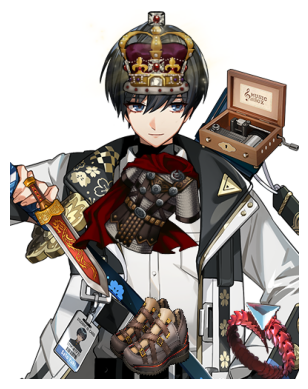

In [9]:
print(f'무기: {weaponNames[weaponNames.code==102405].name.values[0]}', end=', ')
print(f'옷: {armorNames[armorNames.code==202412].name.values[0]}',end=', ')
print(f'머리: {armorNames[armorNames.code==201409].name.values[0]}',end=', ')
print(f'팔: {armorNames[armorNames.code==203410].name.values[0]}',end=', ')
print(f'다리: {armorNames[armorNames.code==204406].name.values[0]}',end=', ')
print(f'장식: {armorNames[armorNames.code==205309].name.values[0]}')
img = mpl.image.imread('data/mostItem/metaGolem-half.png')
plt.axis('off')
plt.imshow(img)

특이사항

1. 몇몇 캐릭은 스킨이 있음에도 불구하고 기본스킨이 가장 많이 쓰임(쇼우, 아델라, 윌리엄, 나타폰, 아디나, 피올로, 알렉스)
        (1). 비인기 캐릭: 쇼우, 나타폰
        (2). 스킨이 기본일러만 못한 캐릭: 윌리엄, 알렉스
        (3). 원인 불명: 아디나, 아델라, 피올로

2. 보통은 최신스킨이나 등급이 높은 스킨이 가장 많이 쓰이는데 유키의 경우는 초기 스킨인 사관후보생 유키가 가장 많이 쓰임



평균 MMR획득: 9.97, 평균 픽률: 1.19%
재키(단검) 픽률: 1.14%, 승률: 0.27%, 평균 MMR획득: 12.23, 모스트 스킨: 스칼렛 코사지 재키
재키(쌍검) 픽률: 1.07%, 승률: 0.24%, 평균 MMR획득: 8.5, 모스트 스킨: 시스템쇼크 재키
재키(양손검) 픽률: 0.87%, 승률: 0.28%, 평균 MMR획득: 10.14, 모스트 스킨: 재키
재키(도끼) 픽률: 0.36%, 승률: 0.23%, 평균 MMR획득: 8.43, 모스트 스킨: 시스템쇼크 재키


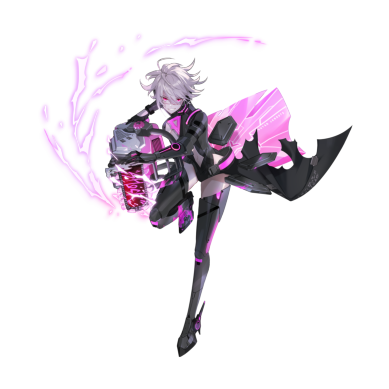

In [18]:
n=input()
img = mpl.image.imread(f'data/mostSkin/{characterNamesKr[characterNamesKr.name==n].code.values[0]}/full.png')
plt.axis('off')
plt.imshow(img)
print(f'평균 MMR획득: {mmr:.2f}, 평균 픽률: {pick:.2f}%')
for _,c in df_characterStats.iterrows():
    if c.characterCode==characterNamesKr[characterNamesKr.name==n].values[0][0]:
        print(f'{c.characterName} 픽률: {c.pickRate}%, 승률: {c.winRate}%, 평균 MMR획득: {c.averageMMR}, 모스트 스킨: {c.mostSkin}')